<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/Entropies_for_cube_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rsautter/gpa/
!pip install git+https://github.com/barauna-lo/GPA.git
!pip install --force-reinstal git+https://github.com/rsautter/eta/
!pip install ordpy

  Cloning https://github.com/rsautter/gpa/ to /tmp/pip-req-build-ox6qmzuw
  Running command git clone --filter=blob:none --quiet https://github.com/rsautter/gpa/ /tmp/pip-req-build-ox6qmzuw
  Resolved https://github.com/rsautter/gpa/ to commit 2c011bb317699305375b9847baf7a6f4509c0b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for GPA: filename=GPA-3.5-cp310-cp310-linux_x86_64.whl size=1510273 sha256=9a7250a877bba27fef1a3a55f4b8ad24859adb87f65789b7d7e05a5065cd15f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wyx9_k14/wheels/cf/d3/01/6bc4b9ee1b7099c44ec5622ba091557ebb46215dac6ed99069
Successfully built GPA
  Cloning https://github.com/barauna-lo/GPA.git to /tmp/pip-req-build-a2oz2rfn
  Running command git clone --filter=blob:none --quiet https://github.com/barauna-lo/GPA.git /tmp/pip-req-build-a2oz2rfn
  Resolved https://github.com/barauna-lo/GPA.git to commit 2c011bb317699305

In [3]:
# import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import inset_locator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset#, transFigure
from scipy.stats import linregress
import os
# import cv2
# import NCGL
import eta
import tqdm
from ordpy import *
from GPA import GPA
import glob
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, ifftn
from tqdm import tqdm

def colored_noise(shape, beta):
    random_noise = np.random.normal(size=shape)
    kx = np.fft.fftfreq(shape[0]).reshape(-1, 1, 1)
    ky = np.fft.fftfreq(shape[1]).reshape(1, -1, 1)
    kz = np.fft.fftfreq(shape[2]).reshape(1, 1, -1)
    freq_grid = np.sqrt(kx**2 + ky**2 + kz**2)
    freq_grid[0, 0, 0] = 1  # Avoid division by zero
    spectrum = fftn(random_noise) * np.power(freq_grid, -beta / 2.0)
    colored = np.real(ifftn(spectrum))
    return colored
# Generate data
betas = np.linspace(1, 5, 5)
noise_cubes = []
for i, beta in enumerate(betas):
    noise_cubes.append(colored_noise((64, 64, 64), beta))

In [8]:
ga = GPA(0.0)
s = noise_cubes[0][0]
GPAs = ga(s,moment=['G1','G2','G3','G4'])
print(GPAs)


{'G1': 0.022293188803381086, 'G2': 0.9940239733632423, 'G3': 0.7479569283881535, 'G4': (1.093566646489467-0.02681769656849813j)}


In [7]:
entropies = eta.entropy(noise_cubes[0])
print(entropies)


{'Histogram_Shannon': 0.91491858749003, 'Permutation_Shannon': 0.9988708843012211, 'Spectral_Shannon': 0.9582319306723098, 'Histogram_PowerlawTsallis': nan, 'Permutation_PowerlawTsallis': nan, 'Spectral_PowerlawTsallis': nan}


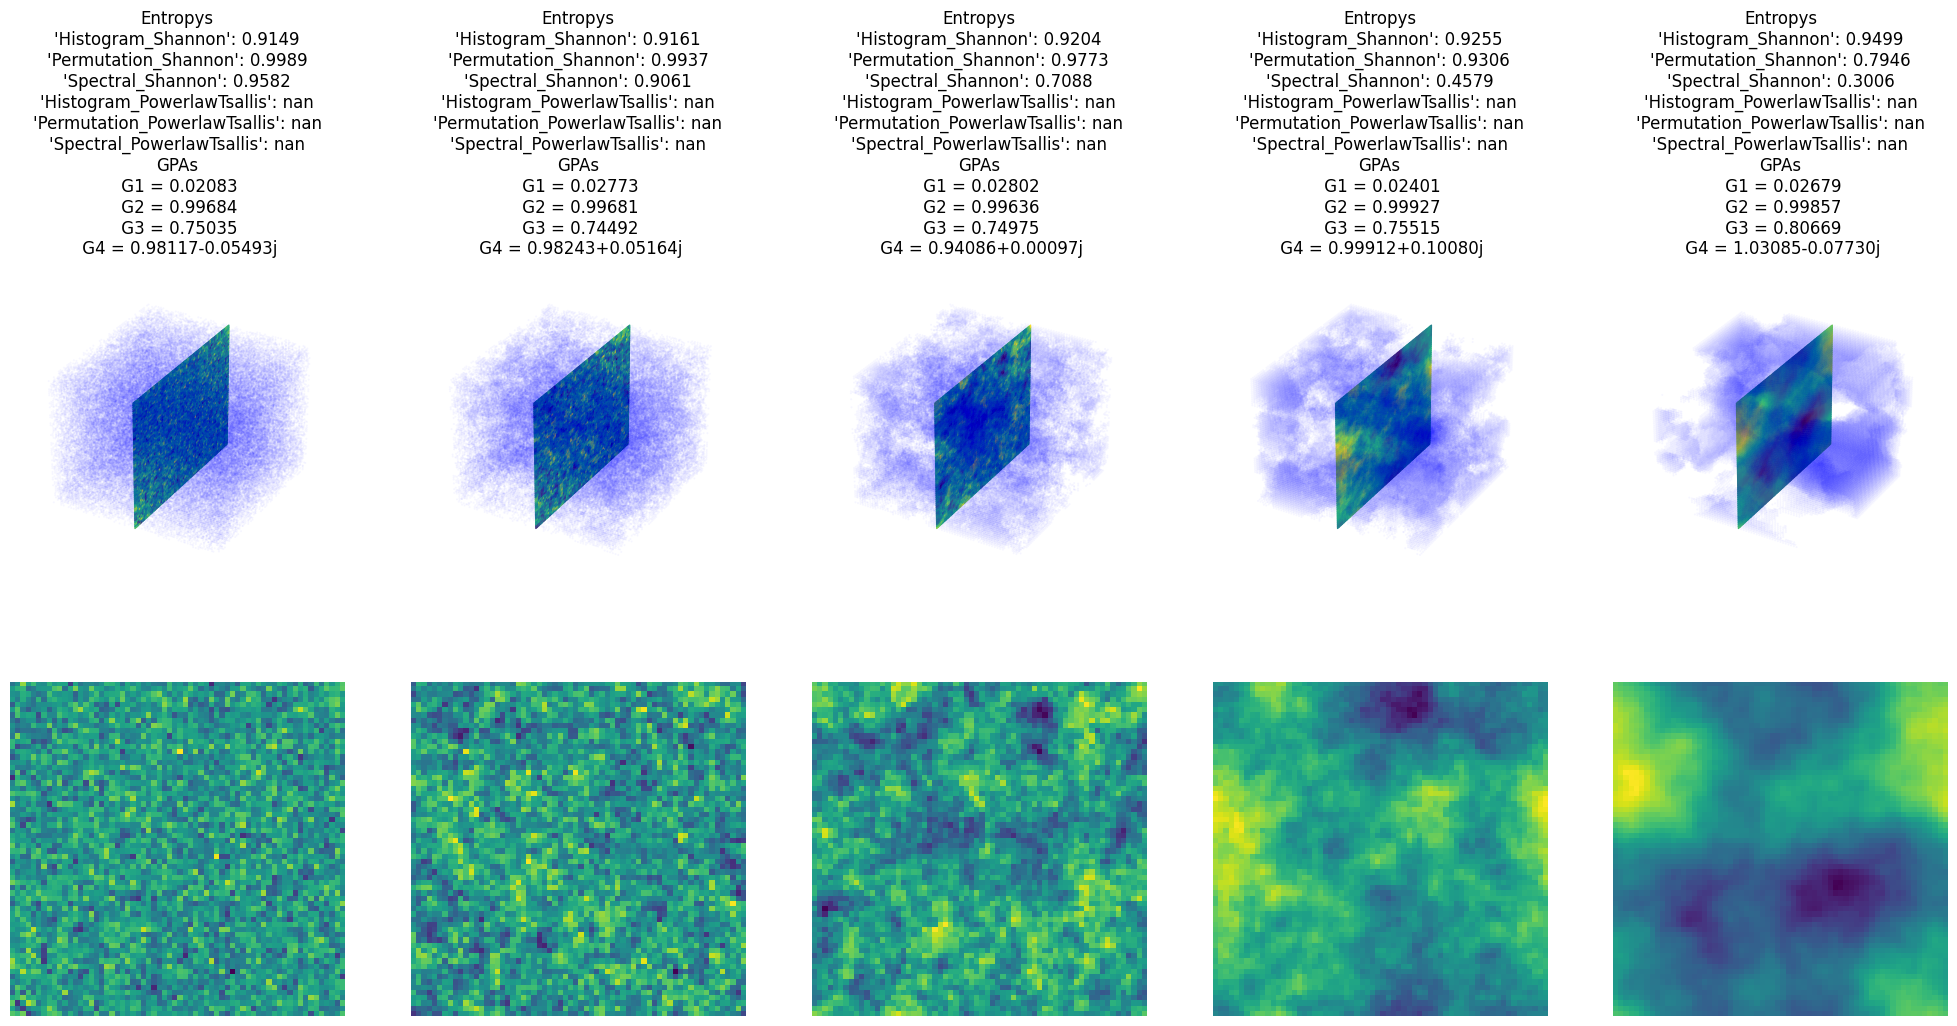

In [6]:
selected_slice = 32
ga = GPA(0.0)
fig = plt.figure(figsize=(25, 10))#,dpi=300)
for i, beta in enumerate(betas):
    noise_cube = noise_cubes[i]
    # Plot 3D noise cube in the first row

    entropies = eta.entropy(noise_cube)
    entropies = {key: round(value, 4) for key, value in entropies.items()}
    entropies = str(entropies).replace(", ", "\n").strip("{").strip("}")

    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    x, y, z = np.indices((noise_cube.shape[0],noise_cube.shape[1],noise_cube.shape[2]))
    mask = noise_cube > noise_cube.mean() + 0.2 * noise_cube.std()
    ax.scatter(x[mask], y[mask], z[mask], alpha=0.03, color='blue',s=0.3)

    # Extract the selected slice for 3D plotting
    central_slice = noise_cube[selected_slice, :, :]
    Y, Z = np.meshgrid(range(noise_cube.shape[0]),range(noise_cube.shape[1]))
    X = np.full(Y.shape, selected_slice)

    GPA_central_slice = ga(central_slice,moment=['G1','G2','G3','G4'])

    # Plot the selected slice on the 3D plot
    colors = plt.cm.viridis((central_slice - central_slice.min()) / (central_slice.max() - central_slice.min()))
    ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, shade=False,alpha=0.8)

    #ax.set_title(f'Beta = {beta}',fontsize=32)
    ax.set_title(f'Entropys\n{entropies}\nGPAs\n G1 = {GPA_central_slice["G1"]:.5f}\n G2 = {GPA_central_slice["G2"]:.5f}\n G3 = {GPA_central_slice["G3"]:.5f}\n G4 = {GPA_central_slice["G4"]:.5f}',fontsize=12)
    ax.axis('off')

    # Plot 2D slice in the second row
    ax2 = fig.add_subplot(2, 5, i+6)
    ax2.imshow(np.flipud(central_slice), cmap='viridis')
    # ax2.set_title(f'Beta = {beta}')
    ax2.axis('off')